In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time

import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Read the data 

In [2]:
#Read training data
train = pd.read_csv('train.tsv', sep = '\t').head(100000)

#Read testing data
test = pd.read_csv('test.tsv', sep = '\t').head(60000)

## Data Quality Check 

In [3]:
# Check train dataset
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
# Check test dataframe
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [5]:
# CHeckthe type of features, and see if there are any inconsistencies
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
# Check more information about the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
train_id             100000 non-null int64
name                 100000 non-null object
item_condition_id    100000 non-null int64
category_name        99583 non-null object
brand_name           57076 non-null object
price                100000 non-null float64
shipping             100000 non-null int64
item_description     100000 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 6.1+ MB


In [7]:
# The information above indicates there are missing values in some columns
# Check for columns with missing values
train.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description     False
dtype: bool

In [8]:
# Check for missing values in test dataset
test.isnull().any()

test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name            True
shipping             False
item_description     False
dtype: bool

In [9]:
# What is the shape of training set?
print('The shape of the train dataset is', train.shape)

#What is the shape of the test set?
print('The shape of the test dataset is', test.shape)

The shape of the train dataset is (100000, 8)
The shape of the test dataset is (60000, 7)


In [10]:
# Function to create combined set. 
# You would want to apply count vectorizer on combined set so you can get the list of all possible words.
def combineTrainTestSet():
    all_data = pd.concat((train.drop(['train_id', 'price'], axis = 1),
                          test.drop(['test_id'], axis = 1))).reset_index(drop=True)

    # Create the submission set (Only contains the test IDs)
    submission = test[['test_id']]

    # size of train
    train_size = len(train)
    
    return (all_data, submission, train_size)

## Data Cleansing 

### Data with 0 price 

In [11]:
# check data which has price as 0
print('Count of records with 0 prices:', train[train['price']==0].shape[0])

Count of records with 0 prices: 65


In [12]:
# deleting all records that have price as 0
train = train[train['price']!=0].reset_index()

In [13]:
# utilize function created earlier to create various data slices
all_data, submission, train_size = combineTrainTestSet()

## Missing values 

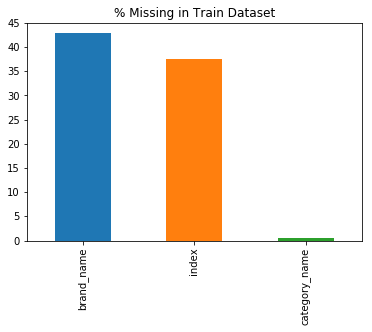

In [14]:
#count number of missing values in each column
missing_total = all_data.isnull().sum().sort_values(ascending=False)

#calculate percent of missing values in each column 
percent = (all_data.isnull().sum()*100/all_data.isnull().count().sort_values(ascending=False))

#create a dataframe with missing values and percents
missing_data = pd.concat([missing_total, percent], axis=1, keys =['Total', 'Percent'])

#plot only columns that have more than 0% data missing
missing_data[missing_data['Percent']>0]['Percent'].sort_values( ascending=False).plot(kind= 'bar', by='Percent', title='% Missing in Train Dataset')

In [15]:
percent

brand_name           42.825523
category_name         0.434552
index                37.515241
item_condition_id     0.000000
item_description      0.000000
name                  0.000000
shipping              0.000000
dtype: float64

## Imputation or fill missing data

In [16]:
# For column brand_name, if it's blank, we can assume it is unbranded
all_data['brand_name'] = all_data['brand_name'].fillna('unbranded')

# For column category_names, we can fill missing values with "other"
all_data['category_name'] = all_data['category_name'].fillna('other/other/other')


## Data Correction

In [17]:
# make all strings lowercase to remove case dependancy for string match
all_data = all_data.applymap(lambda s: s.lower() if type(s) == str else s)

#some item_description have values "no description yet" and some have "no description"
#replace these with "none" using lambda function which checks each row of the column

all_data['item_description'] = all_data['item_description'].apply(lambda x: 'none' if x== 'no description yet' else x)
all_data['item_description'] = all_data['item_description'].apply(lambda x: 'none' if x== 'no description' else x)

## Minor feature engineering

In [18]:
# The category name is of the form "General category/Subcategory1/Subcategory2"
# Let us segregate it in 3 columns

def segregate_category(text):
    try: return text.split("/")
    except: return ("other", "other", "other")

In [19]:
#apply the function created above to generate new columns with various categories split
all_data['category_main'], all_data['category_sub1'],all_data['category_sub2'] = zip(*all_data['category_name'].apply(segregate_category))

In [20]:
#add correction to account for "other" replacement with pre-exisitng categories
#if category_sub1 is other, use main category:
all_data.loc[all_data['category_sub1']=='other', 'category_sub1'] = all_data['category_main']

#if category_sub2 is other use category_sub1
all_data.loc[all_data['category_sub2']=='other', 'category_sub2'] = all_data['category_sub1']

In [21]:
# function to update changes in train and test set
def updateTrainTestDataset():
    global train
    global test
    ntrain = train.shape[0]
    ntest = test.shape[0]
    
    label = train['price']
    train = all_data[:ntrain] # get only the train rows from all_data
    train['price'] = label
    test = all_data[ntrain:].reset_index().drop(['index'], axis = 1)

In [22]:
updateTrainTestDataset()

## Exploratory Data Analysis 

In [23]:
all_data.astype('object').describe().transpose()

,count,unique,top,freq
brand_name,159935,2451,unbranded,68493
category_name,159935,1037,"women/athletic apparel/pants, tights, leggings",6419
index,99935,99935,99999,1
item_condition_id,159935,5,1,68799
item_description,159935,143606,none,8963
name,159935,141999,bundle,293
shipping,159935,2,0,88526
category_main,159935,10,women,71783
category_sub1,159935,120,athletic apparel,14448
category_sub2,159935,798,t-shirts,6582


### Observations: 
1. women is the most popular category
2. most of the products sold are unbranded

## Target variable: Price 

In [24]:
train.price.describe()

count    99935.000000
mean        26.715770
std         37.948666
min          3.000000
25%         10.000000
50%         17.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

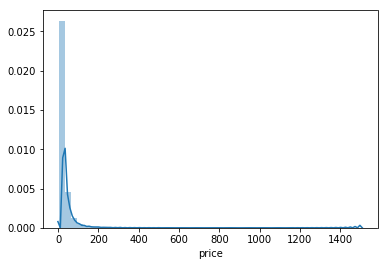

In [25]:
#histogram
sns.distplot(train['price'])

In [26]:
# % of products selling above $100
train[train['price']>100]['price'].count()/train.shape[0]*100

2.841847200680442

## Summary

* The min value of price is 0. There are 65 products for 0 dollars.
* The mean price is 26.7 USD
* The third quartile of the price is on 29 USD, while the max value is 1506 USD. Thats a huge difference.
* The price is highly skewed.
* Only 2.84 percent of products have its price higher than 100 USD value.

### Actions to take
Log transformation has to be applied on price.

#### Why log transformation? 
The price distribution is highly skewed, e.g., only 2.84% of data is more than 100 dollars and the max value is 1506 dollars. This reduces the relevance of the errors (in the predicted value) on lower prices. Log transformation converges the distribution to a smaller scale, which means that the difference between different values of price will reduce. This, in turn, would make the distribution more normal.

## Procedure

Step 1 Log Transformation: np.log(train['price']+1)

Step 2 Predict with Log Transformation: test_pred = model.predict(X_test)

Step 3 Convert back to original value by Exponential Transformation Y_test = np.expm1(test_pred)

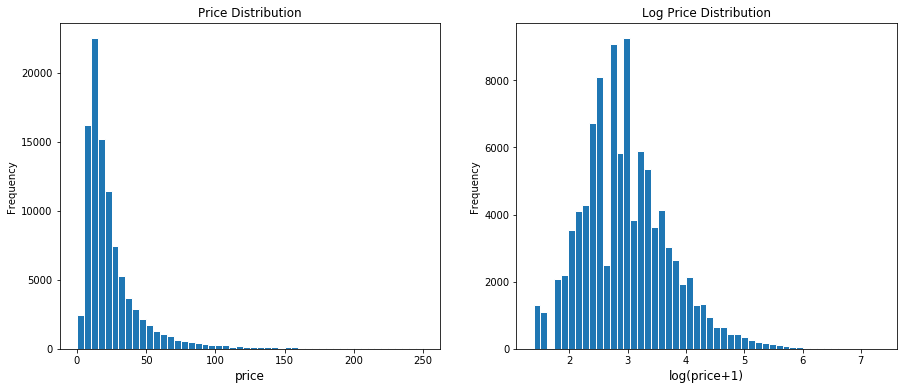

In [27]:
# Plot Price Distribution
plt.subplot(1,2,1)
(train['price']).plot.hist(bins=50, figsize=(15,6), edgecolor = 'white', range = [0,250])
plt.xlabel('price', fontsize = 12)
plt.title('Price Distribution', fontsize = 12)

# Check the distribution after transformation
plt.subplot(1,2,2)
np.log(train['price']+1).plot.hist(bins=50, figsize = (15,6), edgecolor = 'white')
plt.xlabel('log(price+1)', fontsize = 12)
plt.title('Log Price Distribution', fontsize = 12)

plt.show()

In [28]:
y_train = np.log1p(train['price'])

## Shipping

In [29]:
all_data['shipping'].value_counts()/len(all_data)

0    0.553512
1    0.446488
Name: shipping, dtype: float64

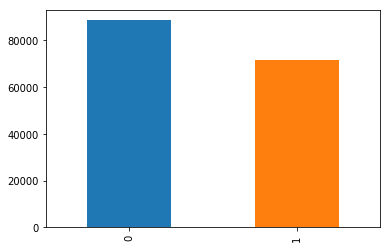

In [30]:
all_data['shipping'].value_counts().plot.bar()

### Observation:  
* For 55% of the products, the shipping is paid by buyer

## Price Distribution by Shipping Type 

In [31]:
#Hypothesis: Product price is higher when seller pays shipping

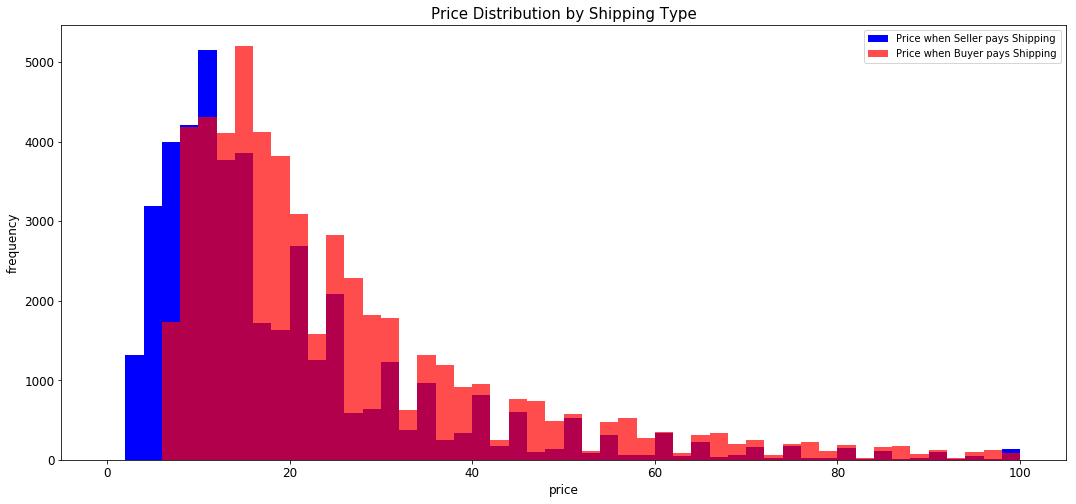

In [32]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_fee_by_seller, color='blue', alpha = 1, bins = 50, range=[0, 100], label = 'Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='red', alpha = 0.7, bins = 50, range=[0, 100], label = 'Price when Buyer pays Shipping')

plt.xlabel('price', fontsize = 12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize = 12)
plt.legend()
plt.show()

### Average price for Shipping Type 

In [33]:
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(),2)), 'if seller pays shipping')
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(),2)), 'if buyer pays shipping')


The average price is 22.48 if seller pays shipping
The average price is 30.15 if buyer pays shipping


## Item Condition 

In [34]:
all_data['item_condition_id'].value_counts()*100/len(all_data)

1    43.016851
3    29.228749
2    25.462219
4     2.123988
5     0.168193
Name: item_condition_id, dtype: float64

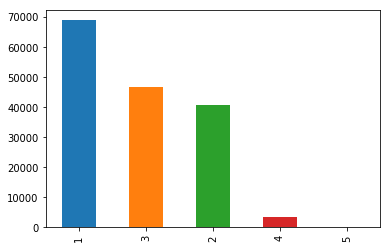

In [35]:
all_data['item_condition_id'].value_counts().plot.bar()

### Observation
* About 72% of the products sold are in a good condition

### Category 

In [36]:
all_data['category_main'].value_counts()*100/len(all_data)

women                     44.882609
beauty                    14.093225
kids                      11.505924
electronics                8.257730
men                        6.275674
home                       4.526214
other                      3.545190
vintage & collectibles     3.154406
handmade                   2.070841
sports & outdoors          1.688186
Name: category_main, dtype: float64

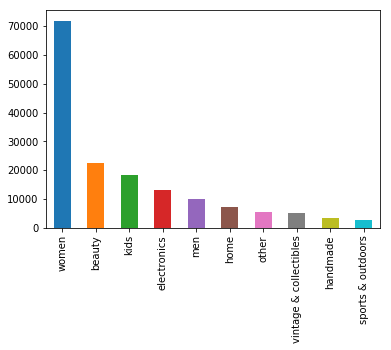

In [37]:
all_data['category_main'].value_counts().plot.bar()

### Category versus Price 

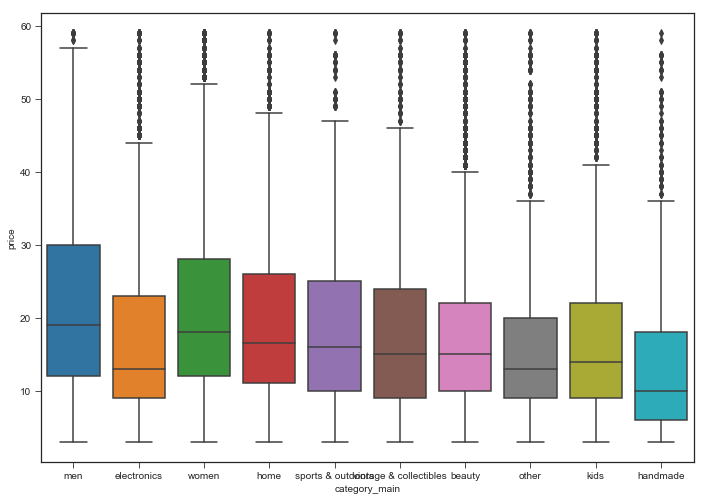

In [38]:
#plot
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7,8.27)

sns.boxplot(
x= 'category_main',
y = 'price',
data = train[train['price']<60],
ax=ax)

### Observation
* Men's category has the highest median price, while handmade category has lowest median price

In [39]:
# checking the top 20 subcategory1 values 
top_20_subcategory1 = all_data['category_sub1'].value_counts()[:20].reset_index()
top_20_subcategory1

,index,category_sub1
0,athletic apparel,14448
1,makeup,13499
2,tops & blouses,11432
3,shoes,10877
4,jewelry,6690
5,toys,6268
6,cell phones & accessories,5787
7,dresses,4977
8,women's handbags,4856
9,women's accessories,4566


In [40]:
#save data to list for plotting
list(top_20_subcategory1['index'])[0:10]

['athletic apparel',
 'makeup',
 'tops & blouses',
 'shoes',
 'jewelry',
 'toys',
 'cell phones & accessories',
 'dresses',
 "women's handbags",
 "women's accessories"]

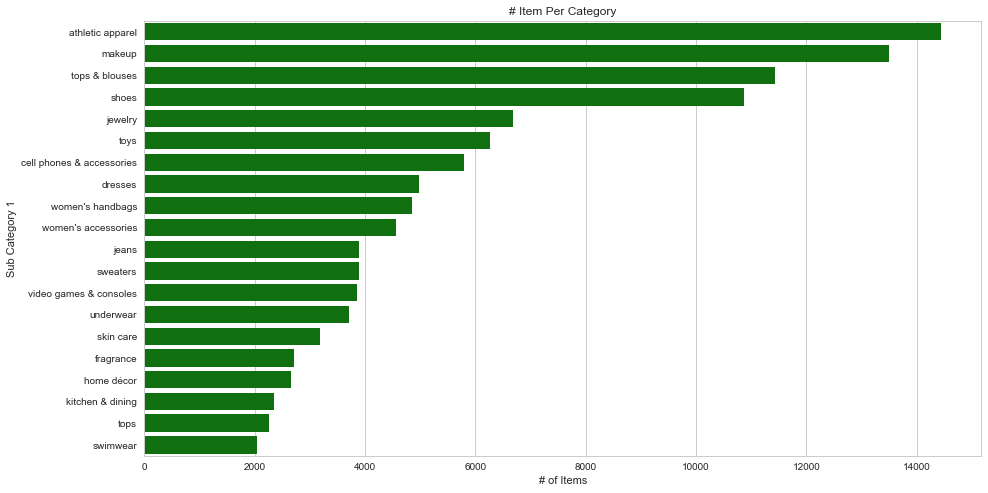

In [41]:
sns.set(style='whitegrid')

# Initialize matplotlib figure
f, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='category_sub1', y = 'index', data = top_20_subcategory1, label='# Item per category', color = 'g')

# Add legend and axis information
ax.set(ylabel = "Sub Category 1", title = '# Item Per Category', xlabel = '# of Items')
plt.show()

### Subcategory 2 

In [42]:
# Lets explore the top 20 subcateogry 2
top_20_subcategory2 = all_data['category_sub2'].value_counts()[:20].reset_index()
top_20_subcategory2

,index,category_sub2
0,t-shirts,6582
1,"pants, tights, leggings",6419
2,face,5343
3,shoes,3493
4,lips,3341
5,games,3220
6,athletic,2992
7,women,2907
8,eyes,2874
9,"cases, covers & skins",2679


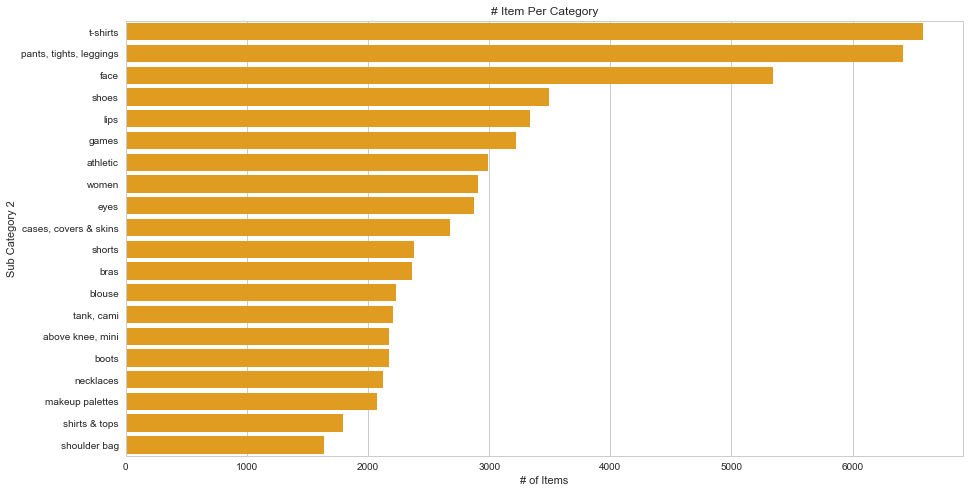

In [43]:
sns.set(style='whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x='category_sub2', y='index', data=top_20_subcategory2, label='# Item per category', color='orange')

# Add a legend and informative axis label
ax.set( ylabel="Sub Category 2", title='# Item Per Category',
       xlabel="# of Items")

plt.show()

In [44]:
# Lets compare number of brands in complete dataset and the training data
all_data['brand_name'].nunique()

2451

In [45]:
# Number of unique brand names in training set
train['brand_name'].nunique()

2065

### Observation
* atheletic apparel is the most popular subcategory1 and t-shirts is the most popular subcategory2.
* There are more brand names in the combined data, as compared to training data.

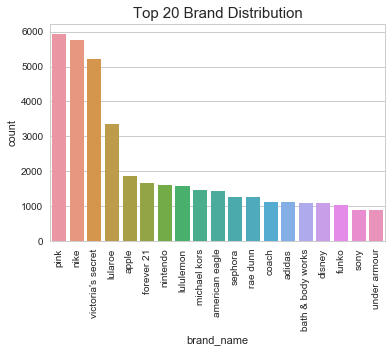

In [46]:
# Top 20 Brand Distribution excluding "unbranded" 
b20 = all_data['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'brand_name', 'brand_name':'count'})
ax = sns.barplot(x="brand_name", y="count", data=b20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Brand Distribution', fontsize=15)
plt.show()


In [47]:
all_data['brand_name'].value_counts().sort_values(ascending=False)

unbranded             68493
pink                   5925
nike                   5751
victoria's secret      5220
lularoe                3348
apple                  1862
forever 21             1666
nintendo               1622
lululemon              1595
michael kors           1478
american eagle         1429
sephora                1277
rae dunn               1265
coach                  1134
adidas                 1127
bath & body works      1102
disney                 1091
funko                  1028
sony                    908
under armour            900
old navy                821
carter's                703
the north face          699
urban decay             688
hollister               682
independent             645
too faced               617
xbox                    612
brandy melville         594
mac                     572
                      ...  
academy                   1
spense                    1
prabal gurung             1
giuseppe zanotti          1
bp                  

#### Observations: 
* There are 68493 products which are either unbranded or of unknown brand.
* Pink and Nike are the top brands whose products are sold in Mercari.

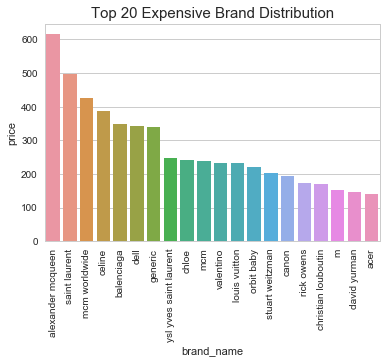

In [48]:
# Top 20 expensive brands
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

## Feature Engineering 

### Is Branded

In [49]:
# Let us make a new feature "is_branded". If the item is of any known brand, we will update it with 1, otherwise 0.
all_data.loc[(all_data.brand_name != 'unbranded'),'is_branded'] = 1
all_data.loc[(all_data.brand_name == 'unbranded'),'is_branded'] = 0
updateTrainTestDataset()

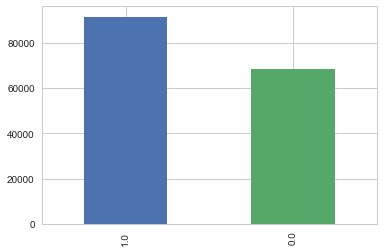

In [50]:
# Is Branded distribution
all_data['is_branded'].value_counts().plot.bar()

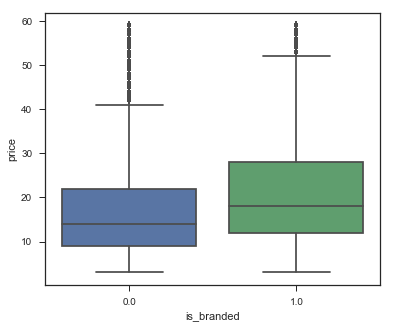

In [51]:
# Is branded versus price
# plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(6, 5)

sns.boxplot(
    x='is_branded',
    y='price',
    data=train[train['price'] < 60],
    ax = ax
)

### Observation
* Branded items sell at higher median price

###  Item Description and Name length

In [52]:
# Does the length of description and name have some affect on pricing?

In [53]:
description_length = all_data['item_description'].astype(str).apply(lambda x : len(str(x)))
name_length = all_data['name'].astype(str).apply(lambda x : len(str(x)))
all_data['length'] = description_length + name_length
updateTrainTestDataset()

### Description length versus price

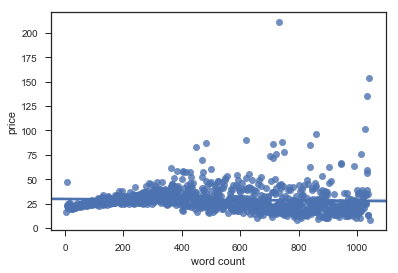

In [54]:
df = train.groupby('length')['price'].mean().reset_index()
sns.regplot(x=df["length"], y=(df["price"]))
plt.xlabel("word count")
plt.show()

### Unique word count on Item Description and Name

In [55]:
def count_unique(text):
    text_list = text.split()
    return len(set(text_list))

description_unique = all_data['item_description'].astype(str).apply(lambda x : count_unique(str(x)))
name_unique = all_data['name'].astype(str).apply(lambda x : count_unique(str(x)))
all_data['unique'] = description_unique + name_unique
updateTrainTestDataset()

###  Count of unique words in description versus price

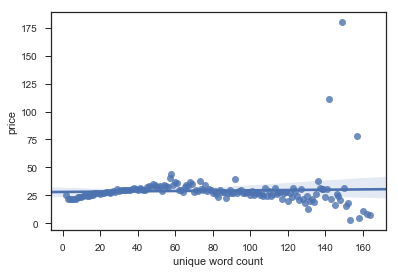

In [56]:
df = train.groupby('unique')['price'].mean().reset_index()
sns.regplot(x=df["unique"], y=(df["price"]))
plt.xlabel("unique word count")
plt.show()

## Feature Extraction from Text

In [57]:
# import nltk
# nltk.download('stopwords')
# generating list of stop words
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [58]:
# generating list of punctuation marks
punctuation_symbols = []
for symbol in punctuation:
    punctuation_symbols.append((symbol, ''))
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [59]:
import string

# Function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# Function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

# Function to remove digits
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [60]:
# Stem the Words
porter = PorterStemmer()
all_data['item_description'] = all_data['item_description'].apply(porter.stem)

all_data['item_description'] = all_data['item_description'].apply(remove_punctuation)
all_data['item_description'] = all_data['item_description'].apply(remove_stop_words)
all_data['item_description'] = all_data['item_description'].apply(remove_digits)

all_data['name'] = all_data['name'].apply(remove_punctuation)
all_data['name'] = all_data['name'].apply(remove_stop_words)
all_data['name'] = all_data['name'].apply(remove_digits)

updateTrainTestDataset()

## Count Vectorizer

In [61]:
# CountVectorizer - name & categories
cv = CountVectorizer(min_df=10) # minimum threshold that words appear more than 10 times 
X_name = cv.fit_transform(all_data['name'])
X_category_main = cv.fit_transform(all_data['category_main'])
X_category_sub1 = cv.fit_transform(all_data['category_sub1'])
X_category_sub2 = cv.fit_transform(all_data['category_sub2'])

In [62]:
#check shape after vectorizing
print("Item Name Shape: " + str(X_name.shape))
print("Category Main Shape: " + str(X_category_main.shape))
print("Category Sub1 Shape: " + str(X_category_sub1.shape))
print("Category Sub2 Shape: " + str(X_category_sub2.shape))

Item Name Shape: (159935, 5239)
Category Main Shape: (159935, 12)
Category Sub1 Shape: (159935, 136)
Category Sub2 Shape: (159935, 611)


## Label Binarizer 

In [63]:
# Apply LabelBinarizer to "brand_name"
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(all_data['brand_name'])

In [64]:
print("Item Brand Shape: " + str(X_brand.shape))

Item Brand Shape: (159935, 2451)


## TFIDF 

In [65]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(all_data['item_description'])

In [66]:
print("Item Description Shape: " + str(X_description.shape))

Item Description Shape: (159935, 55000)


In [67]:
train.shape[0]

99935

In [69]:
# Definte RMSLE Cross Validation Function
def rmse_cv(model):
    kf = KFold(3, True, 1) #allow 3 folds, shuffling and random generator 1
    rmse= np.sqrt(-cross_val_score(model, train['item_description'],y_train, scoring="neg_mean_squared_error", cv = kf))
    print(rmse)
    return(rmse.mean())

## Baseline Model with CountVectorizer and Stop Words 

In [70]:
vec = CountVectorizer()#stop_words='english')
clf = Ridge()
pipe = make_pipeline(vec, clf)
pipe.fit(train['item_description'], y_train)

cv_sw_rmse = rmse_cv(pipe)  

print("The Validation Score is: " + str(cv_sw_rmse))

[0.67858133 0.67675463 0.67364417]
The Validation Score is: 0.6763267118310289


## Baseline Model with TF-IDF, Stop Words and N-Grams 

In [71]:
vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
clf = Ridge()
pipe = make_pipeline(vec, clf)
pipe.fit(train['item_description'], y_train)

tfidf_sw_ng_rmse = rmse_cv(pipe)

print("The Validation Score is: " + str(tfidf_sw_ng_rmse))

[0.6190938  0.61646718 0.61894912]
The Validation Score is: 0.6181700339238959


## RMSLE Summary

In [72]:
print ("RMSE Score: " + str(cv_sw_rmse) + " | CountVectorizer | Stop Words")
print ("RMSE Score: " + str(tfidf_sw_ng_rmse) + " | TF-IDF | Stop Words | N-Grams")

RMSE Score: 0.6763267118310289 | CountVectorizer | Stop Words
RMSE Score: 0.6181700339238959 | TF-IDF | Stop Words | N-Grams


## Encoding 

In [73]:
# Apply get_dummies to "item_condition_id" and "shipping" and then convert into a CSR Matrix
X_dummies = csr_matrix(pd.get_dummies(all_data[['item_condition_id', 'shipping']], sparse=True).values)

## Merge the Sparse Matrices 

In [74]:
# converting numerical columns to matrix
X_numerical = all_data[['is_branded', 'length', 'unique']].as_matrix()

# Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_name, X_category_main, X_category_sub1, X_category_sub2, X_numerical)).tocsr()

In [75]:
sparse_merge.shape

(159935, 61003)

## Train and Test Split 

In [76]:
X_train_sparse = sparse_merge[:train_size]
X_test = sparse_merge[train_size:]

## Define RMSE Function

In [77]:
def get_rmse(y, pred): 
    return np.sqrt(mean_squared_error(y, pred))

## Ridge Regression Cross Validation 

In [78]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train_sparse):
    # Define LGBM Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_ridge.fit(X_train_sparse[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(X_train_sparse[train_ids])
    rmse_train = get_rmse(y_train[train_ids], y_pred_train) 
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(X_train_sparse[valid_ids])
    rmse_valid = get_rmse(y_train[valid_ids], y_pred_valid)
    
    print(f'Ridge Training RMSE: {rmse_train:.5f}')
    print(f'Ridge Validation RMSE: {rmse_valid:.5f}')

Ridge Training RMSE: 0.62783
Ridge Validation RMSE: 0.62960
Ridge Training RMSE: 0.62810
Ridge Validation RMSE: 0.62732
Ridge Training RMSE: 0.62677
Ridge Validation RMSE: 0.63059
Wall time: 1min 41s


### Decision Tree Regressor with Cross Validation

In [79]:
%%time

# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(X_train_sparse):
    # Define LGBM Model
    model_dtr = DecisionTreeRegressor(max_depth=15, max_leaf_nodes=200, random_state=42)
    
    # Fit LGBM Model
    model_dtr.fit(X_train_sparse[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_dtr.predict(X_train_sparse[train_ids])
    rmse_train = get_rmse(y_train[train_ids], y_pred_train)
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_dtr.predict(X_train_sparse[valid_ids])
    rmse_valid = get_rmse(y_train[valid_ids], y_pred_valid)
    
    print(f'DecisionTree Training RMSE: {rmse_train:.5f}')
    print(f'DecisionTree Validation RMSE: {rmse_valid:.5f}')

DecisionTree Training RMSE: 0.60836
DecisionTree Validation RMSE: 0.62854
DecisionTree Training RMSE: 0.60777
DecisionTree Validation RMSE: 0.62944
DecisionTree Training RMSE: 0.60720
DecisionTree Validation RMSE: 0.62868
Wall time: 44.1 s


## Ensemble

In [80]:
#train Test Split
train_X, test_X, train_y, test_y = train_test_split(X_train_sparse, y_train, test_size=0.2, random_state=42)

### Ridge Regression

In [81]:
model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
model_ridge.fit(train_X, train_y)
    
# Evaluate Training Score
ridge_y_pred = model_ridge.predict(test_X)

In [82]:
ridge_rmse = get_rmse(test_y, ridge_y_pred)

print(f'Ridge RMSE: {ridge_rmse:.5f}')

Ridge RMSE: 0.63006


### Decision Tree Regressor

In [83]:
model_dtr = DecisionTreeRegressor(max_depth=15, max_leaf_nodes=200, random_state=42)
model_dtr.fit(train_X, train_y)
    
# Evaluate Training Score
dtr_y_pred = model_dtr.predict(test_X)

In [84]:
dtr_rmse = get_rmse(dtr_y_pred, test_y)

print(f'Ridge RMSE: {dtr_rmse:.5f}')

Ridge RMSE: 0.62884


### Ensemble

In [85]:
ensemble_y_pred = (dtr_y_pred+ridge_y_pred)/2

ensemble_rmse = get_rmse(ensemble_y_pred, test_y)

print(f'Ensemble RMSE: {ensemble_rmse:.5f}')

Ensemble RMSE: 0.61297


##  Save models

In [86]:
import pickle

modelList = [(model_dtr, 'DTR.sav'),
            (model_ridge, 'RidgeRegression.sav')]

for model, filename in modelList:
    pickle.dump(model, open("models_"+filename, 'wb'))

## Predictions on Kaggle Test data

### Prediction by Ridge

In [87]:
ridge_kaggle_y = model_ridge.predict(X_test)

In [88]:
# inverse log transformation
submission["price"] = np.expm1(ridge_kaggle_y)

In [89]:
# first submission file
submission.to_csv('submission_ridge.csv',index=False)

### Predictions by DTR

In [90]:

dtr_kaggle_y = model_dtr.predict(X_test)

In [91]:
# inverse log transformation
submission["price"] = np.expm1(dtr_kaggle_y)

In [92]:
# second submission file
submission.to_csv('submission_dtr.csv',index=False)

### Predictions by Ensemble

In [93]:
ensemble_y_kaggle = (dtr_kaggle_y+ridge_kaggle_y)/2

# inverse log transformation
submission["price"] = np.expm1(ensemble_y_kaggle)

# third submission file
submission.to_csv('submission_ensemble.csv',index=False)